# Purpose of the Notebook

# Problem Statement

# Module Import

In [1]:
import os
#uncomment this if you want to run on your CPU instead of GPU
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import datetime
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

#to speed up pandas operands
from pandarallel import pandarallel

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, classification_report
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import tensorflow.keras.utils as ku 

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


import emoji

from project5_utils import my_print
from project5_utils import my_wait

from MyMovieReview import MovieReview
from MyMovieReview import MovieReviewGenerator

from mymovie import Movie

In [2]:
print("tensorflow version is {}".format(tensorflow.__version__))
print("keras version is {}".format(keras.__version__))


tensorflow version is 2.3.1
keras version is 2.4.0


In [3]:
%matplotlib inline 

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
LOG_FILE = open("../Data/notebook.log","w")
DEBUG = 1

In [6]:
#Setting these for now will adjust them
VOCAB_SIZE = 400000
BASELINE_EMBEDDING_DIM = 32
GLOVE_EMBEDDING_DIM = 100
#will calc this based on training set
#MAX_LENGTH = 1000
TRUC_TYPE = "post"
PAD_TYPE = "post"
#Out of Value Token -- or token to indicate a 
OOV_TOK = "<OOV>"

TRAIN_SET_PERCENT =  90.0
EPOCHS = 100
RANDOM_STATE = 42

BATCH_SIZE = 96

In [7]:
tensorflow.random.set_seed(RANDOM_STATE)

# Data Processing
Get reviews from PKL files into format that can be tokenized

In [8]:
MOVIE_REVIEWS_PKL_FILE = open("../Data/Reviews_back14.pkl","rb")

list_of_movie_reviews = []

while 1:
    try:
        temp_review = pickle.load(MOVIE_REVIEWS_PKL_FILE)
        list_of_movie_reviews.append(temp_review)
        my_print("added this review to the list ==>\n{}\n".format(temp_review), DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE reading movie reviews", DEBUG, LOG_FILE)
        break
        
MOVIE_REVIEWS_PKL_FILE.close()
print("Number of movie reviews read: {}".format(len(list_of_movie_reviews)))

Number of movie reviews read: 62718


In [9]:
col_names = list(list_of_movie_reviews[0].__dict__.keys())
#col_values = list(list_of_movie_reviews[0].__dict__.values()) --> TODO: REMOVE

In [10]:
list_of_movie_review_lists = []

for review_col_name in col_names:
    list_of_movie_review_data_vals = []
    
    for review_obj in list_of_movie_reviews:
        list_of_movie_review_data_vals.append ( review_obj.__dict__[review_col_name] )
        
    list_of_movie_review_lists.append(list_of_movie_review_data_vals)
    
reviews_dict = dict(zip(col_names,list_of_movie_review_lists))
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.head()

,review_text,review_star_rating,reviewer_name,directlink_url,reviewlink_url,title,review_title,review_date
0,At the end of this movie there's a shot of the...,2,veardleyw,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4675276/,On the Basis of Sex,"Feeble, telemovie-style travesty of a potentia...",20 February 2019
1,The film starts in 1956 with RBG (Felicity Jon...,8,nogodnomasters,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4783407/,On the Basis of Sex,It's not a movement if everyone is just sitting.,15 April 2019
2,This well meaning movie shows the discriminati...,5,phd_travel,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4590175/,On the Basis of Sex,Well intentioned but miscast,18 January 2019
3,Why would you make a movie about the second fe...,1,Viking131313,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4621289/,On the Basis of Sex,Makes no sense.,2 February 2019
4,This movie was very well done. Good acting and...,10,MikeChm,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4583636/,On the Basis of Sex,Well worth going to see!,15 January 2019


**CLEANING**



In [11]:
#Get rid of instances of people spamming the same review
reviews_df.drop_duplicates(subset=["review_text"],keep="first",inplace=True)

In [12]:
#Get rid of reviews where "review_star_rating" is missing or "review_text" is missing
mask = (reviews_df["review_text"] == "EMPTY") | (reviews_df["review_star_rating"] == -1)
mask_keep = ~mask

In [13]:
reviews_df = reviews_df[mask_keep]

In [14]:
reviews_df.dropna(inplace=True)

In [15]:
reviews_df.shape

(62612, 8)

In [16]:
text_of_reviews = reviews_df[["review_title","review_text","review_star_rating"]]

Text corpus will be composed of the review title concatenated with the review text

In [17]:
text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]

<ipython-input-17-b4d769d80be9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]


In [18]:
text_of_reviews = text_of_reviews.rename(columns={"review_text":"review_text_original"})

In [19]:
text_of_reviews = text_of_reviews.rename(columns= {"review_observation":"review_text"})

In [20]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text
0,"Feeble, telemovie-style travesty of a potentia...",At the end of this movie there's a shot of the...,2,"Feeble, telemovie-style travesty of a potentia..."
1,It's not a movement if everyone is just sitting.,The film starts in 1956 with RBG (Felicity Jon...,8,It's not a movement if everyone is just sittin...
2,Well intentioned but miscast,This well meaning movie shows the discriminati...,5,Well intentioned but miscast This well meaning...
3,Makes no sense.,Why would you make a movie about the second fe...,1,Makes no sense. Why would you make a movie abo...
4,Well worth going to see!,This movie was very well done. Good acting and...,10,Well worth going to see! This movie was very w...


**Some Statistics**
* Are the classes balanced?
* What's the mean, mode, stddev of the classes?
* Length of reviews: mean, mode, std dev, and all of this for each class

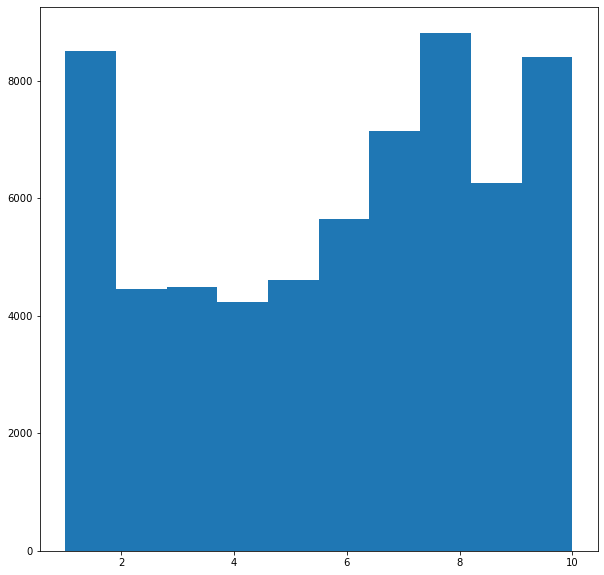

In [21]:
plt.figure(figsize=(10,10))
plt.hist(text_of_reviews["review_star_rating"],10);

In [22]:
text_of_reviews.describe()

,review_star_rating
count,62612.000000
mean,5.844055
std,3.038270
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,10.000000


In [23]:
text_of_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62612 entries, 0 to 62717
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_title          62612 non-null  object
 1   review_text_original  62612 non-null  object
 2   review_star_rating    62612 non-null  int64 
 3   review_text           62612 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [24]:
len(text_of_reviews)

62612

In [25]:
median = text_of_reviews["review_star_rating"].median()
mode = text_of_reviews["review_star_rating"].mode()

print("median = ", median)
print("mode = ", mode)

#mode = text_of_reviews["review_star_rating"].mode(axis=1)

median =  6.0
mode =  0    8
dtype: int64


In [26]:
text_of_reviews["review_star_rating"].value_counts()

8     8816
1     8513
10    8407
7     7155
9     6264
6     5652
5     4618
3     4492
2     4461
4     4234
Name: review_star_rating, dtype: int64

Just some thoughts: I have alot of very good and very bad reviews. Not a lot of 2,3,4,5,6's. I'm worried the precision of the model is going to suffer and it will just be a binary classifier.
🙁

## Cleaning and Lemmatization
To reduce dimentionality of the corpus


In [27]:
def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["review_text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_|\#|\$|\*|\+|\/|\=|\[|\]|\^|\`|\{|\}|\~]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process

In [28]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(remove_html_punct, axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:11:41.292787


In [29]:
text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())

In [30]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["review_text"])
    return temp_tokenized_txt


In [31]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(tokenize_text,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:05.883282


In [32]:
wordNetLemmatizer = WordNetLemmatizer()

In [33]:
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos

In [34]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["review_text"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


In [35]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(lemmatize_it,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:45.907421


In [36]:
pandarallel.initialize()
start_time = datetime.datetime.now()
text_of_reviews["review_text"]  = text_of_reviews.parallel_apply(lambda x : " ".join(x["review_text"]), axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:04.286383


## Stop word removal
Should I do it?

It lowers dimensionality which can improve training time.

But for a sequence model won't removing the stop words hurt the ability of the model to learn sequences that may be indicative of a specific class? In this project I need pretty high precision because I have 10 categories to classify based on text.

Some stuff I've read:

**Pro or Con**:

* https://stackoverflow.com/questions/37325914/should-i-remove-stopwords-when-feed-sentence-to-rnn
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP

Reading the last link I think I should keep the stop words. The star rating applied to a reviews is a form of sentiment about the review. If a reviewer says "I was not happy with the ending of the movie," stop word removal may convert that to "happy movie ending". This may result in two reviews containing the words "happy movie ending": One with a review of 2 and another with a review of 8 with the original text for the latter score being "I was happy with the ending of the movie."

So will not do stop word removal for now but will keep in as an option if results seem to call for it.


## Converting Star Rating To Net Promoter Score
See https://www.netpromoter.com/know/ for more details

In [37]:
#shifting range of ratings from 1,10 to 0,9
text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1

In [38]:
def gen_net_promoter(row):
    if row["review_star_rating"] <= 6:
        #Detractor
        return 0
    elif row["review_star_rating"] <= 8:
        #Passive
        return 1
    else:
        ##Promotor
        return 2

In [39]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["net_promoter_score"] = text_of_reviews.parallel_apply(gen_net_promoter,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:01.553502


In [40]:
text_of_reviews.shape

(62612, 5)

In [41]:
text_of_reviews["net_promoter_score"].value_counts()

0    39125
1    15080
2     8407
Name: net_promoter_score, dtype: int64

In [42]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
0,"Feeble, telemovie-style travesty of a potentia...",At the end of this movie there's a shot of the...,1,feeble travesty of a potentially fascinating s...,0
1,It's not a movement if everyone is just sitting.,The film starts in 1956 with RBG (Felicity Jon...,7,not a movement if everyone be just sit the fil...,1
2,Well intentioned but miscast,This well meaning movie shows the discriminati...,4,well intentioned but miscast this well mean mo...,0
3,Makes no sense.,Why would you make a movie about the second fe...,0,no sense why would you make a movie about the ...,0
4,Well worth going to see!,This movie was very well done. Good acting and...,9,well worth go to see this movie be very well d...,2


## Train Test Split
Did it this way to preserve incides. I could have did it on the original data frame (TODO).

In [43]:
#Randomizing and doing train test split but preserving indices
train_set_size = int ( ( text_of_reviews.shape[0] * TRAIN_SET_PERCENT ) / 100 )
#test_set_size =  text_of_reviews.shape[0] - train_set_size

review_indices = np.arange(text_of_reviews.shape[0]) 

np.random.seed(RANDOM_STATE)
np.random.shuffle( review_indices)


text_of_reviews = text_of_reviews.iloc[review_indices]

training_indices = review_indices[:train_set_size]
testing_indices = review_indices[train_set_size:]


print(train_set_size)
print(text_of_reviews.shape)
print(training_indices.shape)
print(testing_indices.shape)


56350
(62612, 5)
(56350,)
(6262,)


In [44]:
testing_indices[:3]

array([25613, 14232, 24229])

In [45]:
text_of_reviews_np  = np.array(text_of_reviews)

text_test_set = text_of_reviews_np[testing_indices]
text_train_set = text_of_reviews_np[training_indices]
text_test_set.shape, text_train_set.shape

((6262, 5), (56350, 5))

In [46]:
text_test_set[:1]

array([['You might have a good enough time, for the 87 minutes it takes to watch it.',
        "'CAVEMEN': Two and a Half Stars (Out of Five) Sex comedy flick about a group of mostly unemployed bachelors, living happily together in an LA warehouse, when one decides he wants to give up his sex filled carefree life in order to pursue love. It was written and directed by first time filmmaker Herschel Faber and stars Skylar Astin, Camilla Belle, Chad Michael Murray, Alexis Knapp, Dayo Okeniyi and Kenny Wormald. The cast is full of a lot of recognizable faces, with little name value though; Astin costarred in 'PITCH PERFECT' and '21 & OVER', Murray had major roles on the TV show 'ONE TREE HILL' and in the horror remake 'HOUSE OF WAX', Belle has appeared in indie movies like 'THE BALLAD OF JACK AND ROSE' and big budget bombs like '10,000 BC' and 'PUSH', Okeniyi was in 'THE HUNGER GAMES' and 'THE SPECTACULAR NOW', Wormald starred in the 'FOOTLOOSE' remake and Knapp also appeared in 'PITCH PER

In [47]:
print(text_of_reviews.loc[23136,"review_text"])

every minute of this maybe this movie be just not for everyone but especially towards i think every girl who have a broken heart and to watch a fun movie that very true to life will really enjoy this movie i do


In [48]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
45260,"Disappointing, genre-confused story","Filmmaking 101 has a rule; wait, Art 101 has a...",3,disappointing story a rule wait art a rule kno...,0
36299,"No depth, very slow and absolutely not exciting",When you write a script that wants to tell a s...,2,no depth very slow and absolutely not excite w...,0
5398,"Starts off well, but after that....","Suspiria, as I'm sure anyone reading this is a...",3,off well but after that a sure anyone reading ...,0
51186,Same As It Ever Was.,I did not like the first God's Not Dead. I fou...,1,same a it ever be i do not like the first not ...,0
55765,"Well, if anything, it's a great sleep aid...","Sometimes, ""found footage"" films feel like the...",0,well if anything a great sleep aid sometimes f...,0


In [49]:
#spent hours trying to re-implement train_test_split() :*-(

#train_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_text"]
#train_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_star_rating"]

#train_text_reviews = text_of_reviews.sample(n=train_set_size, random_state=RANDOM_STATE, )

#test_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_text"]
#test_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_star_rating"]

#X = text_of_reviews["review_text"]
#y = text_of_reviews["review_star_rating"]

X_test = text_test_set[:,3]
X_train = text_train_set[:,3]
y_test = text_test_set[:,4]
y_train = text_train_set[:,4]
y_test = y_test.astype("int")
y_train = y_train.astype("int")


Test_Size = 1.0 - (TRAIN_SET_PERCENT/100.0)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Size, random_state=RANDOM_STATE)


In [50]:
#TODO
#Lemmatization
#stop word removal
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(56350,)
(56350,)
(6262,)
(6262,)


In [51]:
Max_Length = max([len(doc) for doc in X_train])
print("Max_Length = {}".format(Max_Length))
CONSTANTS_FILE = open("../Data/constants.pkl","wb")
CONSTANTS = [TRUC_TYPE, PAD_TYPE, OOV_TOK,Max_Length]
pickle.dump(CONSTANTS, CONSTANTS_FILE)
CONSTANTS_FILE.close()

Max_Length = 7779


## Tokenization and Sequence Padding

In [52]:
tokenizer = Tokenizer(oov_token=OOV_TOK, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
total_words = len(tokenizer.word_index)+1
i = 0
for key, value in tokenizer.word_index.items():
    
    if i == 10:
        break
        
    print("word_index[{}] = {}".format(key, value))
    i += 1
    
print("\ntotal words is {}".format(total_words))

word_index[<OOV>] = 1
word_index[the] = 2
word_index[be] = 3
word_index[a] = 4
word_index[and] = 5
word_index[to] = 6
word_index[of] = 7
word_index[it] = 8
word_index[in] = 9
word_index[i] = 10

total words is 29102


In [53]:
TOKENIZER_FILE = open("../Data/project5_tokenizer.pkl","wb")
pickle.dump(tokenizer, TOKENIZER_FILE)
TOKENIZER_FILE.close()
my_print("Done writing out tokenizer file",DEBUG,LOG_FILE)

In [54]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [55]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [56]:
for i, thing in enumerate(X_train_seq):
    if i == 3:
        break
    print("thing = {}".format(thing))

thing = [28, 7, 52, 144, 11, 61, 3, 33, 49, 8, 3, 1179, 10, 70, 8, 61, 3, 27, 13, 3, 156, 69, 2273, 901, 6, 4, 423, 97, 7, 4163, 9, 38, 9156, 1289, 5, 6, 2, 526, 78, 4, 1289, 11, 11, 257, 5, 487, 33, 180, 65, 310, 4, 132, 4, 423, 132, 97, 14, 4, 2939, 180, 85, 119, 10, 145, 11, 131, 6, 23, 14, 2, 13, 241, 10, 3, 62, 8546, 6, 82, 11, 2, 132, 3, 78, 1472, 3888, 3093, 2, 409, 12, 409, 3, 1803, 32, 6, 324, 586, 9, 2, 130, 699, 858, 7, 2, 224, 5, 9, 2, 28, 7, 87, 34, 2, 121, 10, 70, 24, 178, 23, 43, 286, 43, 151, 24, 65, 3, 4, 71, 10, 3, 82, 14, 11, 563, 132, 2, 13, 93, 18, 27, 217, 43, 782, 5, 146, 10, 103, 92, 29, 3, 11, 37, 23, 26, 569, 97, 9, 155, 20, 1737, 92, 20, 1737, 2, 3430, 3, 33, 20, 103, 8, 94, 29, 23, 4, 251, 5, 20, 3, 30, 3, 11, 553, 74, 65, 29, 3, 11, 138, 5, 3, 78, 31, 71, 9, 11, 8, 42, 6, 1472, 78, 10, 70, 24, 3, 138, 27, 25, 15, 24, 3, 43, 94, 2, 218, 9, 6014, 5, 2, 331, 7, 2, 132, 28, 133, 14, 3888, 4, 71, 133, 28, 14, 3093, 78, 4, 52, 33, 133, 15, 99, 25, 3, 4, 13, 39, 5

In [57]:
print(X_train_seq_pad.shape)

(56350, 7779)


In [58]:
#Convert to numpy arrays to work with Tensorflow
X_train_seq_pad = np.array(X_train_seq_pad)
y_train = np.array(y_train)

X_test_seq_pad = np.array(X_test_seq_pad)
y_test = np.array(y_test)



In [59]:
X_train_seq_pad.shape, y_train.shape

((56350, 7779), (56350,))

In [60]:
X_test_seq_pad.shape, y_test.shape

((6262, 7779), (6262,))

In [61]:
X_test_seq_pad[:3]

array([[ 20, 198,  18, ...,   0,   0,   0],
       [447,  13,  27, ...,   0,   0,   0],
       [101, 460,  82, ...,   0,   0,   0]], dtype=int32)

In [62]:
y_test[:3]

array([0, 2, 0])

## Confirming Training/Validation data set has the same distribution as the test set

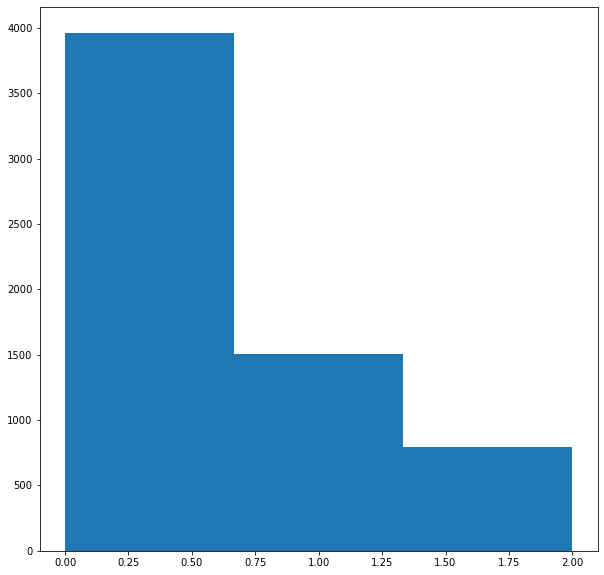

In [63]:
plt.figure(figsize=(10,10))
plt.hist(y_test,3)
plt.show();

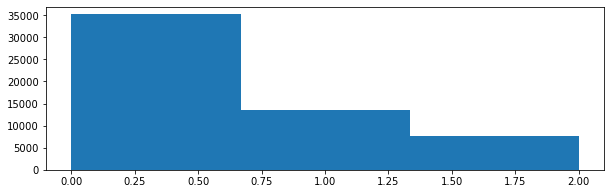

In [64]:
plt.figure(figsize=(10,3))
plt.hist(y_train,3)
plt.show();

Visually the distributions are the same, which I think is important to make sure we are training the model on what it will see in the test set (and hopefully in the wild).

# Baseline Models TODO FIX
The base line model is a custom word embedding providing vectorized words to two layers of 1-D convolutional next networks. According to Chollet a 1-D CNN model can (if properly tuned) do well at text classification.

But the limitation is that if information in the text is highly dependend on the sequence of words, it will be limited. I think because sentiment in English can be highly determined not only by the words used but by the order in which they're used this model won't score well, but is a baseline of how well a simpler-to-train option could do.

TODO: add Reference quoting Chollet

In [65]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 29102


In [66]:
target_names = list(range(3))
target_names = [str(thing+1) for thing in target_names]


In [67]:
#sorted(sklearn.metrics.SCORERS.keys())

## Random Forest Baseline

In [ ]:
########################################################################
##
## TODO: UNCOMMENT THIS AS ANOTHER BASELINE MODEL BEFORE FINAL CHECK IN
##
########################################################################
rf_baseline_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=32)
kfold_obj = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf_baseline_cv_results = cross_validate(rf_baseline_model, X_train_seq_pad, y_train, cv=kfold_obj, n_jobs=32)
rf_baseline_model.fit(X_train_seq_pad, y_train)

In [ ]:
rf_baseline_cv_results

In [ ]:
y_pred_rf = rf_baseline_model.predict(X_test_seq_pad)


In [ ]:
y_pred_rf[:3]

In [ ]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_rf, target_names=target_names))

In [ ]:
rf_confusion = confusion_matrix(y_test, y_pred_rf)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(rf_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)

plt.savefig("../Documents/Images/rf_confusion_matrix.png",dpi=400);

## CNN Baseline

**Class Weights**

In [ ]:
base_model_class_weights_dict = {0:1, 1: 2.31, 2:2.31, 3:2.46, 4:2.309, 5:1.91, 6:1, 7:1, 8:1, 9:1}

In [ ]:
tensorflow.keras.backend.clear_session()


In [ ]:
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(MaxPooling1D(5))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(GlobalMaxPooling1D())
baseline_model.add(Dense(15, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))

my_adam_optimizer = Adam(lr=0.01)

baseline_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model.summary()

In [ ]:
call_back_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [ ]:
training_history = baseline_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list,
                                      validation_split=Test_Size, 
                                      verbose=1)

In [ ]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]
acc = training_history.history["acc"]
val_acc = training_history.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves.png",dpi=400)


In [ ]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves.png",dpi=400)

In [ ]:
y_pred_baseline = baseline_model.predict(X_test_seq_pad)
y_pred_baseline = [np.argmax(y_thing) for y_thing in y_pred_baseline]


In [ ]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [ ]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

In [ ]:
baseline_model_confusion = confusion_matrix(y_test, y_pred_baseline)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline_confusion_matrix.png",dpi=400);

Huge overfit!

Things I need to try:

* Collect more data
* Use a pretrained word embedding
* Regularize
* Add callbacks to make training work harder for me
* which should I use as a loss function: `sparse_categorical_crossentropy` or `categorical_crossentropy`
* Which optimizer should I use: `adam` or `RMSprop(lr=0.1)`
* maybe lemmatization is limiting the ability of the model to distinguish a 0 rating and a 1 rating. I 1 rating may be called "bad" but a zero rating will be called "worst" If you lemmatize both "worst" and "bad" get converted to "bad"

**TODO**:
Find out what it means when val_loss improves by val_acc does not improve.

**ANSWER**
Loss can improve if the proba outputs improve yet do not result in a change in prediction -- hence the loss can improve but if the proba don't flip the decision to the right prediction then accuracy will not improve.

**ANSWER**
You should use `sparse_categorical_crossentropy`


## Test Example

In [ ]:
score, acc = baseline_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

In [ ]:
print(score)

In [ ]:
print(acc)

In [ ]:
#Saving model
baseline_model.save("../Data/baseline_model_arch_weights.h5")

# Updated Model
Will have a model with the following features:

* Pretrained word embedding
* LSTM (or GRU)
* Possibliy bidirectional
* More regularization
* If training is too long: Opt for GRU. Also may opt for a CNN+RNN hybrid


### Pretrained Word Embedding

In [68]:
!./get_word_vectors.sh


File is already downloaded
Done.
Thank you.
Bye.


In [69]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 29102


In [70]:
#build embedding matrix




embedding_dict = {}

GLOVE6B300_FILE = open("../Data/glove.6B.100d.txt","r")

for line in GLOVE6B300_FILE:
    line_values = line.split(" ")
    word = line_values[0]
    vector_components = np.asarray(line_values[1:], dtype="float32")
    embedding_dict[word] = vector_components

Embedding_Matrix = np.zeros((vocab_size, GLOVE_EMBEDDING_DIM))

for word, index_value in word_index.items():
    embedding_vector = embedding_dict.get(word)
    
    if embedding_vector is not None:
        Embedding_Matrix[index_value] = embedding_vector



In [71]:
Embedding_Matrix.shape

(29102, 100)

### Multi Level (DEEP) LSTM Model

Warning: This model takes 1 hour / epic to train and the early `val_acc` is 0.15. You can skip to the next model.

In [72]:
tensorflow.keras.backend.clear_session()


In [ ]:
updated_model = Sequential()
updated_model.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model.add(Bidirectional(LSTM(32, return_sequences=True)))
updated_model.add(Bidirectional(LSTM(32, return_sequences=True)))
updated_model.add(Bidirectional(LSTM(32)))
updated_model.add(Dense(32, activation="relu"))
updated_model.add(Dense(10, activation="softmax"))

my_adam_optimizer = Adam(lr=0.01)
updated_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model.summary()

In [ ]:
call_back_list2 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [ ]:
training_history2 = updated_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list2,
                                      validation_split=Test_Size, 
                                      verbose=1)

Just _one_ epic takes over an hour. Will try a smaller model.

In [ ]:
#loss = training_history2.history["loss"]
#val_loss = training_history2.history["val_loss"]
#acc = training_history2.history["acc"]
#val_acc = training_history2.history["val_acc"]
#epochs = range(1,len(loss)+1)

#plt.figure(figsize=(20,20))
#plt.plot(epochs, loss,"bo",label="Training Loss")
#plt.plot(epochs, val_loss,"b",label="Validation Loss")

#plt.legend()
#plt.show()
#plt.savefig("../Documents/Images/loss_curves2.png",dpi=400)

In [ ]:
#plt.figure(figsize=(20,20))
#plt.plot(epochs, acc,"go",label="Training Acc")
#plt.plot(epochs, val_acc,"g",label="Validation Acc")
#plt.legend()
#plt.show()
#plt.savefig("../Documents/Images/accuracy_curves2.png",dpi=400)

###  Less Complex LSTM Model

In [73]:
tensorflow.keras.backend.clear_session()


In [74]:
updated_model2 = Sequential()
updated_model2.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model2.add( Bidirectional( LSTM(128)) )
#updated_model2.add(Dense(128, activation="relu"))
#updated_model2.add(Dropout(0.2))
#updated_model2.add(Dense(64, activation="relu"))
#updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(32, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(16, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(3, activation="softmax"))


my_adam_optimizer = Adam(lr=0.001)

updated_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 100)         2910200   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 5

In [75]:
call_back_list3 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=6, verbose=1,restore_best_weights=True)
    
    
]

In [76]:
training_history3 = updated_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list3,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
529/529 [==============================] - 329s 622ms/step - loss: 0.8082 - acc: 0.6447 - val_loss: 0.6866 - val_acc: 0.6914
Epoch 2/100
529/529 [==============================] - 329s 622ms/step - loss: 0.6603 - acc: 0.7048 - val_loss: 0.6227 - val_acc: 0.7196
Epoch 3/100
529/529 [==============================] - 329s 622ms/step - loss: 0.6175 - acc: 0.7239 - val_loss: 0.6476 - val_acc: 0.7075
Epoch 4/100
529/529 [==============================] - 329s 622ms/step - loss: 0.5922 - acc: 0.7351 - val_loss: 0.5796 - val_acc: 0.7374
Epoch 5/100
529/529 [==============================] - 331s 625ms/step - loss: 0.5728 - acc: 0.7435 - val_loss: 0.6204 - val_acc: 0.7407
Epoch 6/100
529/529 [==============================] - 330s 624ms/step - loss: 0.5582 - acc: 0.7471 - val_loss: 0.5703 - val_acc: 0.7482
Epoch 7/100
529/529 [==============================] - 329s 622ms/step - loss: 0.5367 - acc: 0.7591 - val_loss: 0.5755 - val_acc: 0.7533
Epoch 8/100
529/529 [====================

In [77]:
score, acc = updated_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

66/66 [==============================] - 18s 265ms/step - loss: 0.5570 - acc: 0.7536


In [78]:
print(score)

0.5569707751274109


In [79]:
print(acc)

0.7535930871963501


In [80]:
y_pred_updated_model2 = updated_model2.predict(X_test_seq_pad)
y_pred_updated_model2 = [np.argmax(y_thing) for y_thing in y_pred_updated_model2]


In [81]:
#target_names = list(range(10))
#target_names = [str(thing) for thing in target_names]


In [82]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_updated_model2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.85      0.91      0.88      3961
           2       0.54      0.53      0.53      1506
           3       0.60      0.42      0.49       795

    accuracy                           0.75      6262
   macro avg       0.66      0.62      0.63      6262
weighted avg       0.74      0.75      0.75      6262



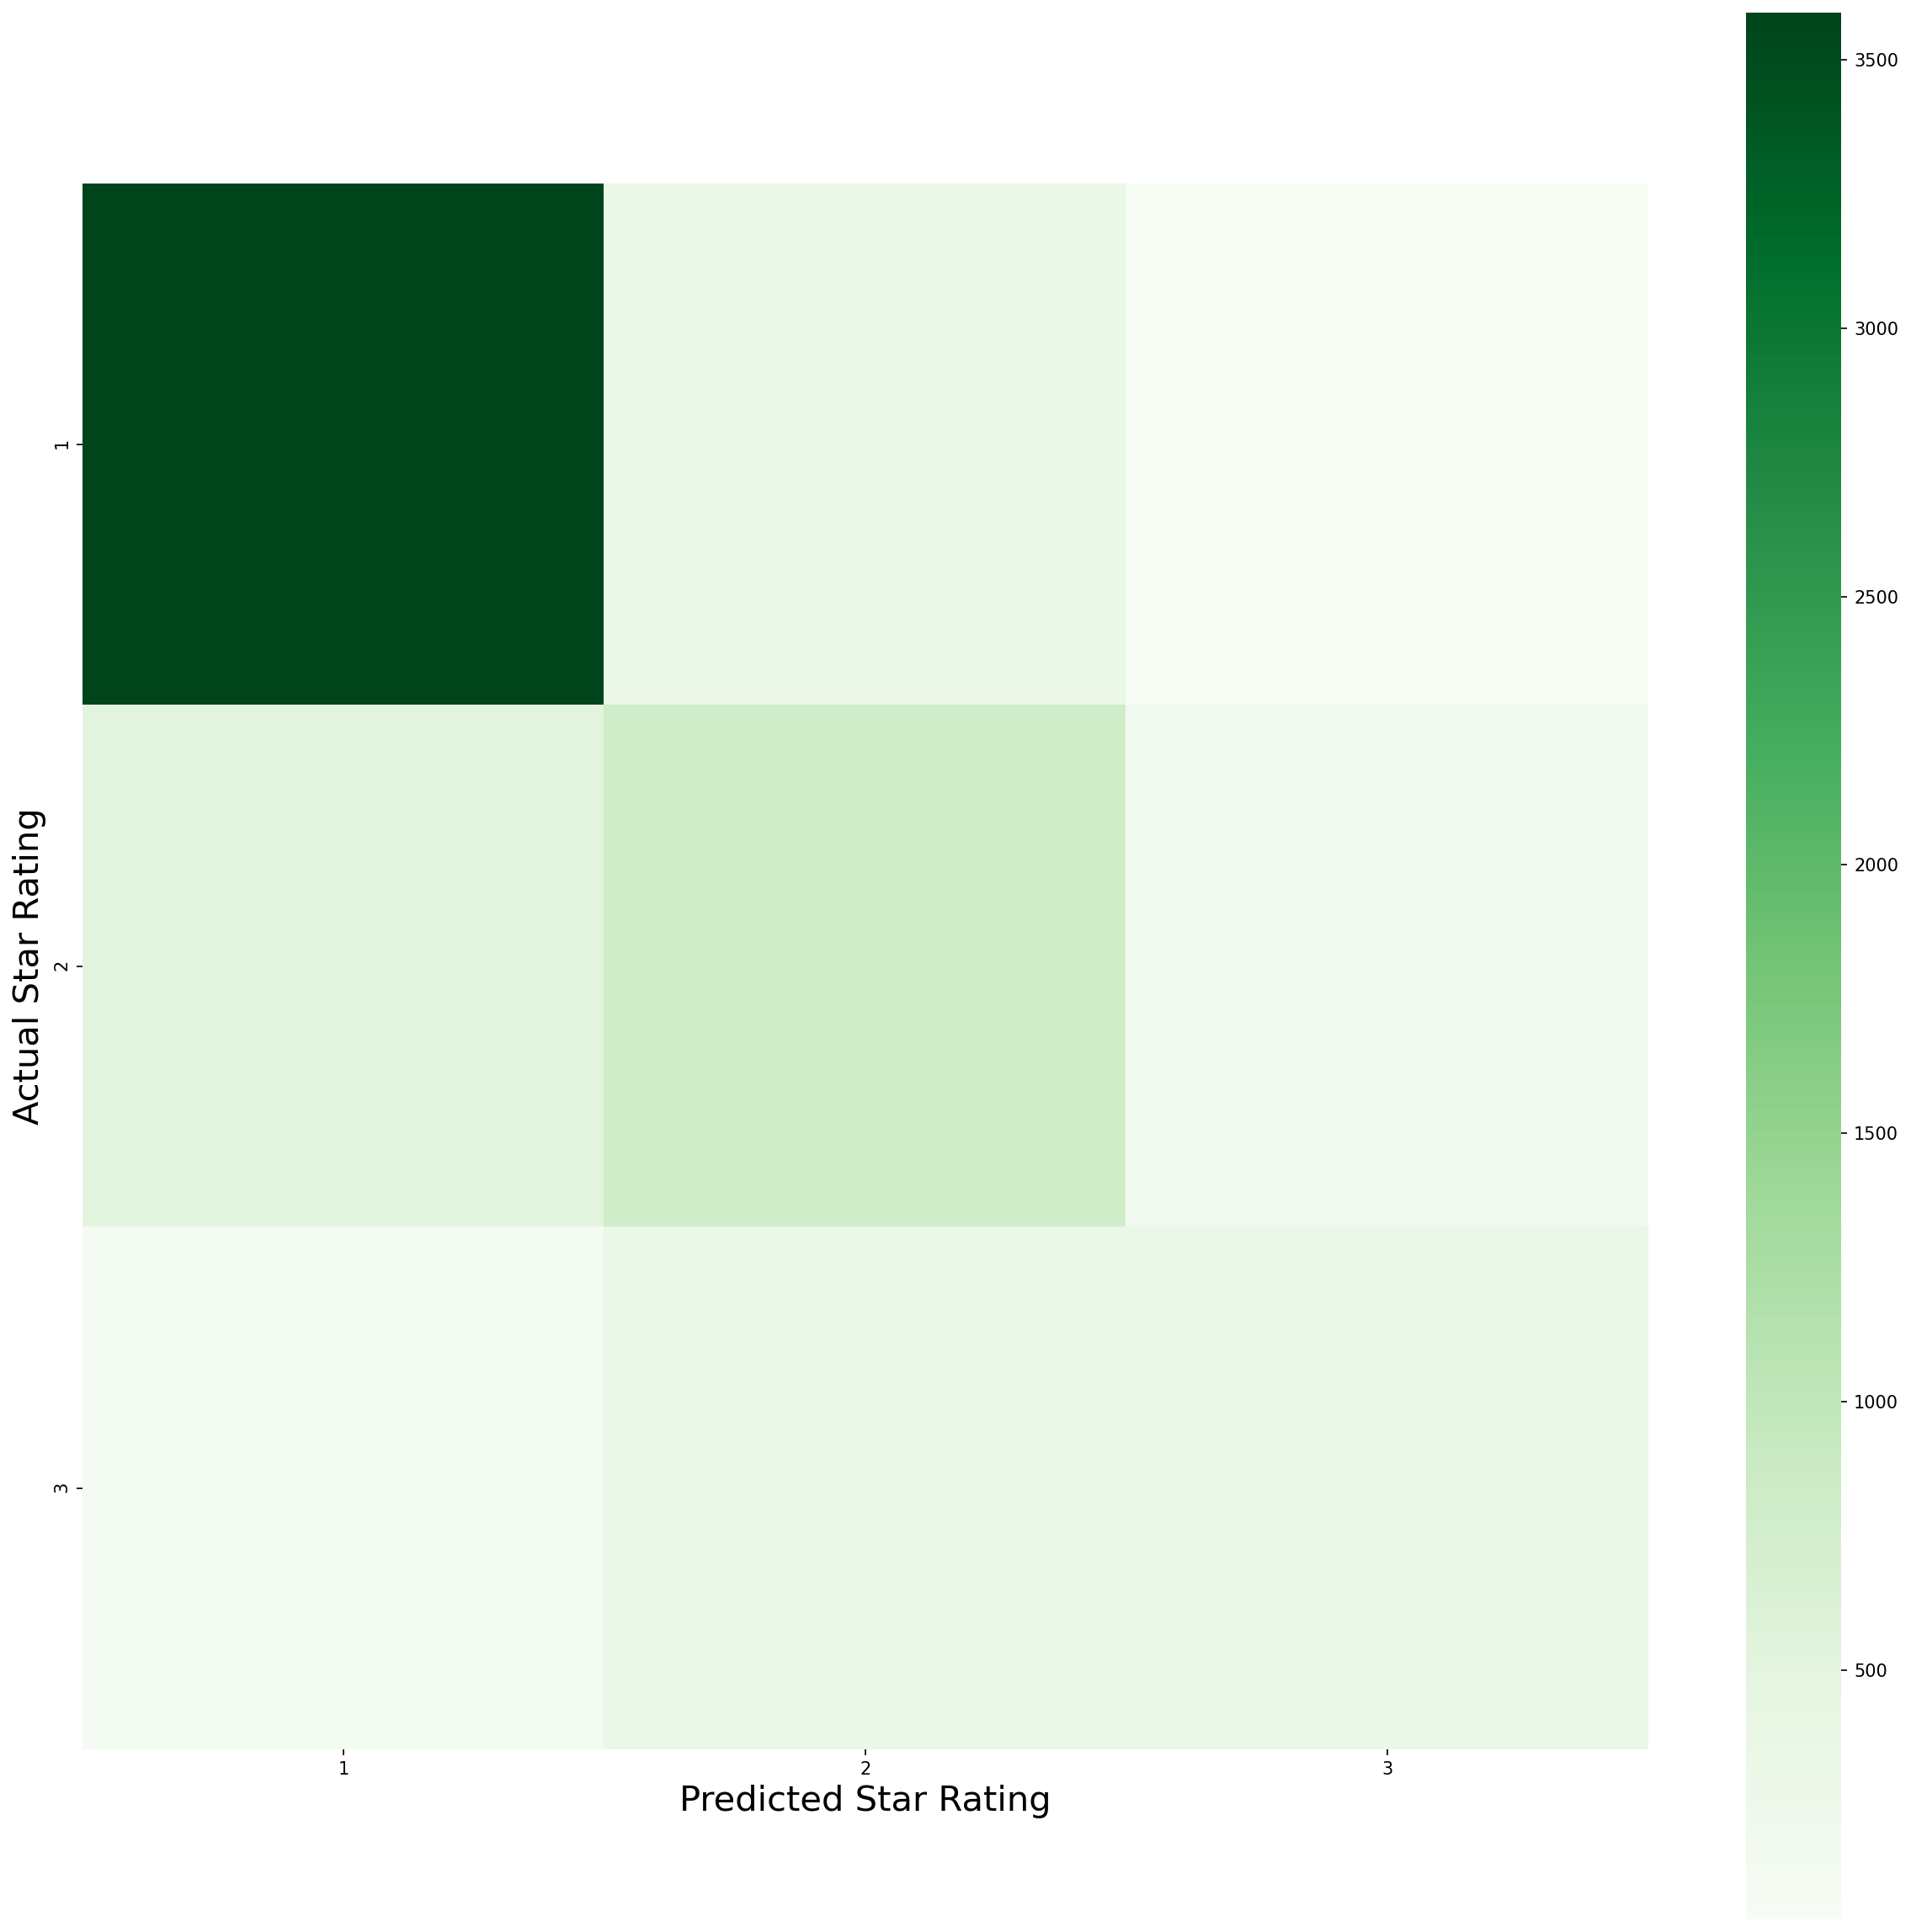

In [83]:
updated_model2_confusion = confusion_matrix(y_test, y_pred_updated_model2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(updated_model2_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating",fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/updated_model2_confusion_matrix.png",dpi=400);

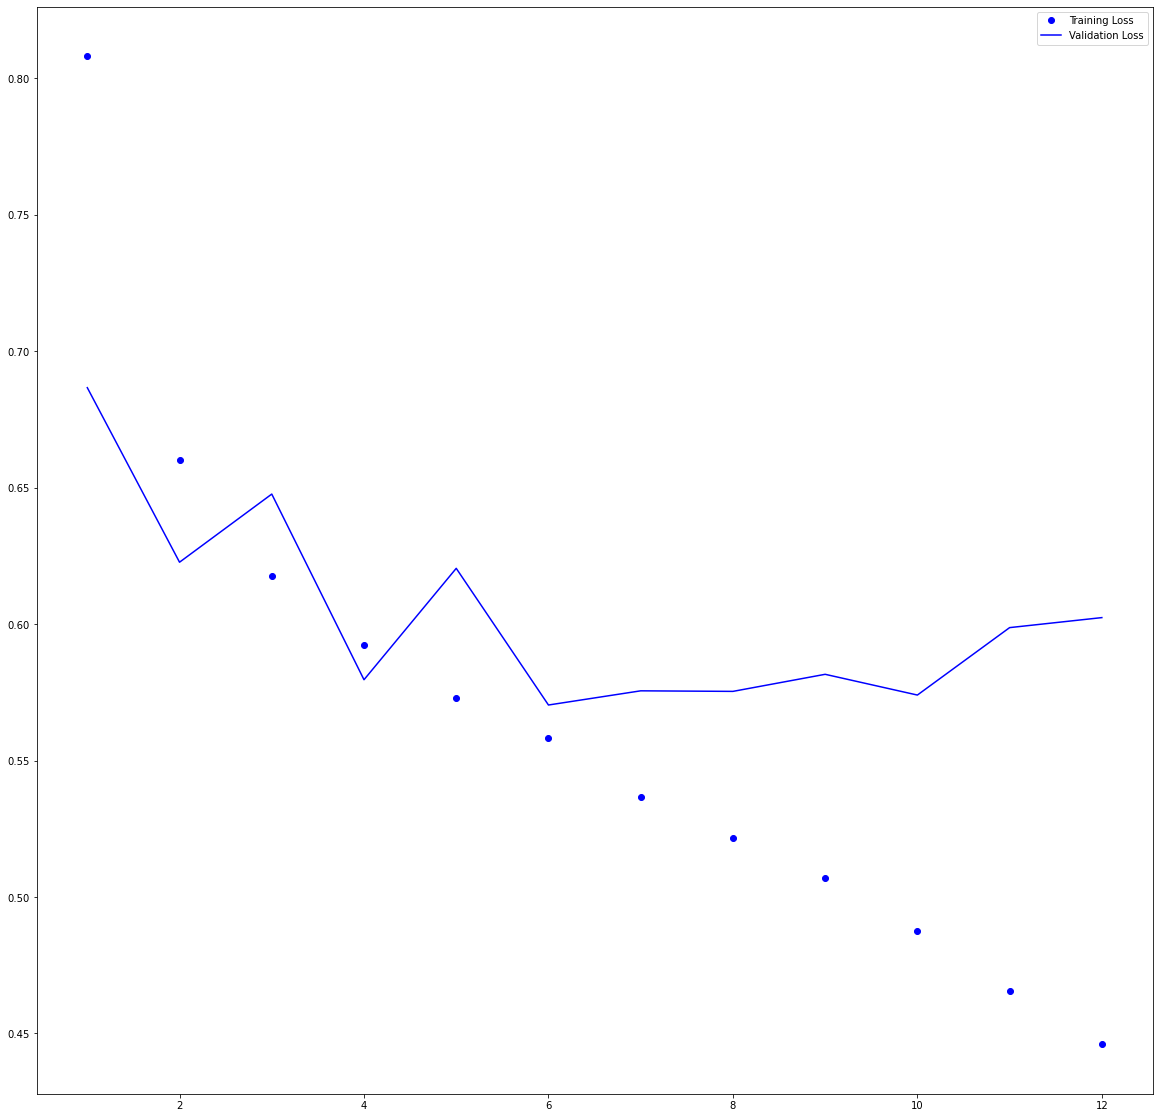

In [84]:
loss = training_history3.history["loss"]
val_loss = training_history3.history["val_loss"]
acc = training_history3.history["acc"]
val_acc = training_history3.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves_update_model2.png",dpi=400)

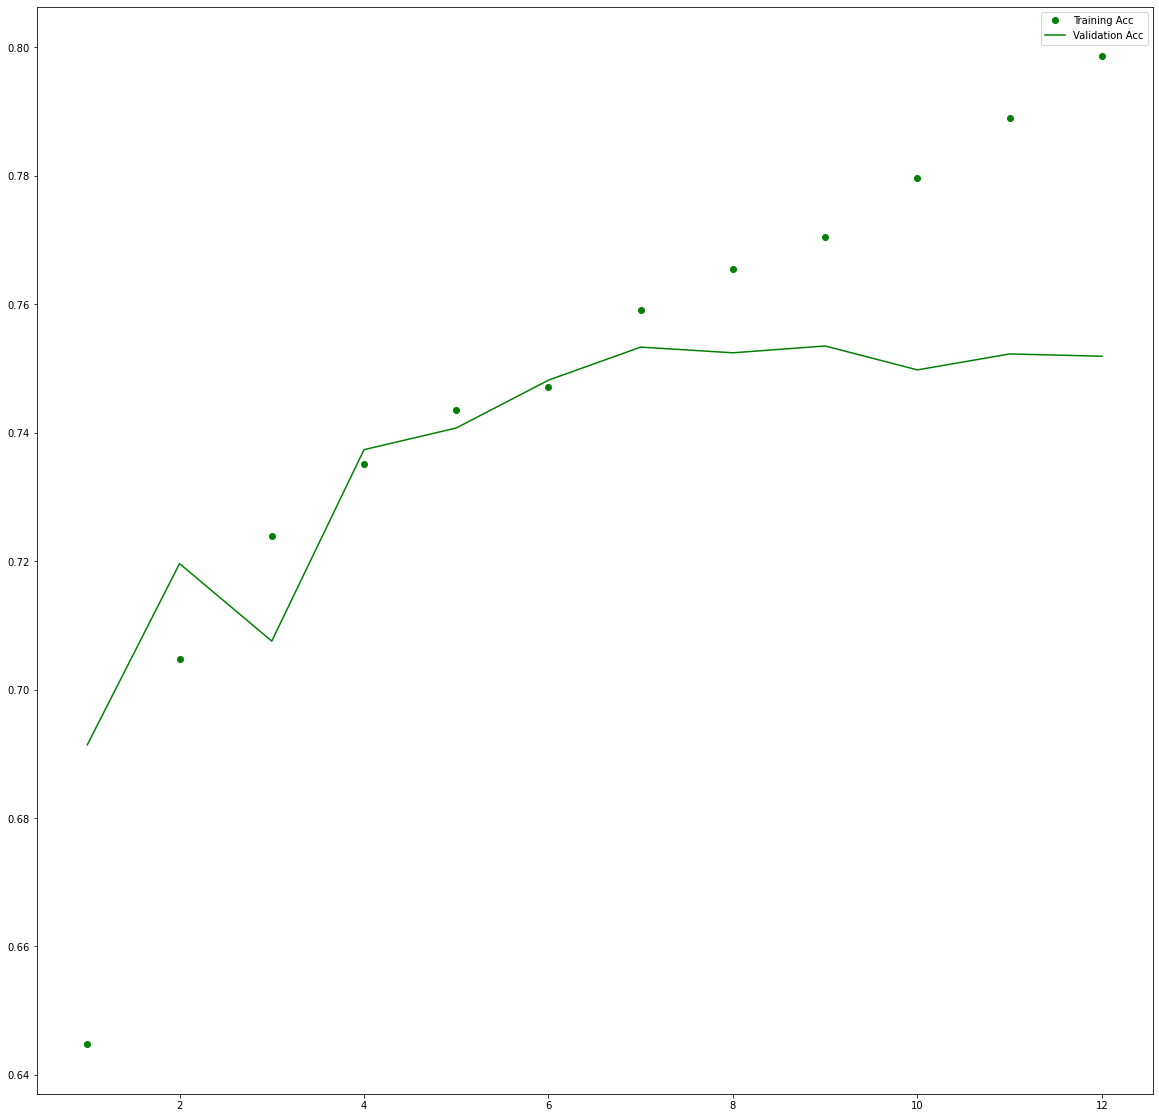

In [85]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves_update_model2.png",dpi=400)

In [86]:
#Saving model
updated_model2.save("../Data/updated_model2_arch_weights.h5")

### More Complex CNN

In [ ]:
tensorflow.keras.backend.clear_session()


In [ ]:
baseline_model2 = Sequential()
baseline_model2.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(Conv1D(32,9,activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#           kernel_regularizer=regularizers.l2(0.0006))
    )
baseline_model2.add(MaxPooling1D(5))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(
    Conv1D(32,
           9,
           activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#    kernel_regularizer=regularizers.l2(0.0007))
)
baseline_model2.add(MaxPooling1D(5))
baseline_model2.add(Conv1D(
    32,
    9,
    activation="relu",
    kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
    #kernel_regularizer=regularizers.l2(0.0007))
)
#baseline_model2.add(GlobalMaxPooling1D())
baseline_model2.add(Flatten())
#baseline_model2.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.015)))
baseline_model2.add(Dense(64, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(32, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(16, activation="relu"))
#baseline_model2.add(Dropout(0.2))
#baseline_model2.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.0007)))
baseline_model2.add(Dense(3, activation="softmax"))
my_adam_optimizer = Adam(lr=0.01)

baseline_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model2.summary()

In [ ]:
call_back_list4 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 5
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [ ]:
training_history4 = baseline_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list4,
                                      validation_split=Test_Size, 
                                      verbose=1)

In [ ]:
score, acc = baseline_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

In [ ]:
print(score)

In [ ]:
print(acc)

In [ ]:
loss = training_history4.history["loss"]
val_loss = training_history4.history["val_loss"]
acc = training_history4.history["acc"]
val_acc = training_history4.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_loss_curves.png",dpi=400)


In [ ]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_accuracy_curves.png",dpi=400)

In [ ]:
y_pred_baseline2 = baseline_model2.predict(X_test_seq_pad)
y_pred_baseline2 = [np.argmax(y_thing) for y_thing in y_pred_baseline2]


In [ ]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [ ]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline2, target_names=target_names))

In [ ]:
baseline_model2_confusion = confusion_matrix(y_test, y_pred_baseline2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model2_confusion, cmap=plt.cm.Blues, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline2_confusion_matrix.png",dpi=400);

# Error Analysis
Find 3 predictions the CNN got right that the RF got wrong



    


In [ ]:


#my_results = [<index in test_indices>, <correct_cnn_label>, <incorrect_rf_label>]
my_results = []
number_of_examples = 0

for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if number_of_examples == 3:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        number_of_examples += 1


# Conclusion

In [ ]:
my_results

In [ ]:
example_indices = testing_indices[my_results[:][0]] 

In [ ]:
example_indices

In [ ]:
pd.options.display.max_colwidth = None

In [ ]:
text_of_reviews.iloc[example_indices,:]

In [ ]:
#Fives where CNN got it right RF got it wrong
Rating = 0
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1



In [ ]:
my_results = np.array(my_results)

In [ ]:
my_results

In [ ]:
my_results[:,0]

In [ ]:
example_indices = testing_indices[my_results[:,0]] 

In [ ]:
example_indices

In [ ]:
text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 9
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1
my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
#examples of where CNN got it wrong
Rating = 2
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 4
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 1
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]